# Example 4 - Export to GDS

This is an example of exporting an IDT design to a GDS. Note that here gdspy package is required.

It includes also a setup with few IDTs and their respective contacts for characterization purposes.

## Imports

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from idtpy import designer
import gdspy
from idtpy.gdsutils import GdsAssistant # it needs gdspy

# Export to GDS an IDT

<IPython.core.display.Javascript object>


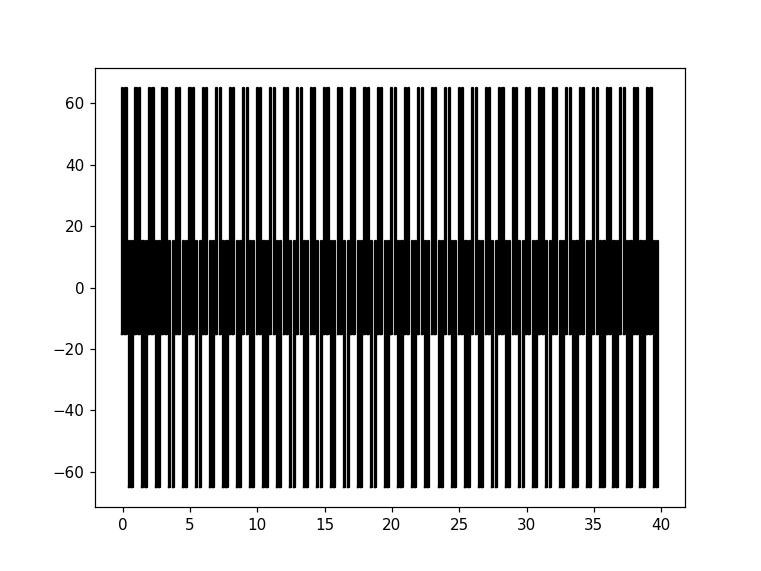

Saved: example4_regularIDT.gds


In [2]:
reg = designer.Regular(freq=2.77,vsaw=2.77,Np=40,w=30,l=50,Nehp=2,tfact=[0.8,0.64,20])

library = 'idtpy'
filename = 'example4_regularIDT.gds'

""" Preview """
fig, ax = plt.subplots(1)
reg.show(ax, color='k')

""" Export to GDS """
gds = GdsAssistant(library)
top = gds.new_cell('top')
top.add(gds.get_gds_polygons(reg,layer=0))
gds.save(filename)
print(f'Saved: {filename}')

# Export a set of IDTs and contacts

In [3]:
""" Create GND """
gnd = designer.Ground(dx=2000,dy=2000,center=(0,0))

""" Generate a regular IDT and a detector IDT """
reg = designer.Regular(freq=1,vsaw=1,Np=40,w=30,l=50,Nehp=2,tfact=1)
det = designer.Regular(freq=1,vsaw=1,Np=1.5,w=30,l=50,Nehp=2,tfact=1)

""" Center the IDTs """
det.align('c').reflect('x',local=True)
reg.align('c')

""" Make copies for left and right IDTs """
left,right = reg.copy(), reg.copy()

""" Translate to a given separation """
sep = 1000
left.align('r').translate(dx=-sep/2)
right.align('l').translate(dx=sep/2)

""" Generate contacts """
pos, neg = [], []
for loc, idt in zip(['tl','tr'],[left,right]):
    p, n = designer.idt_contact(idt,loc=loc,dx=200,dy=60,gap=40,clen=25,ext=20)
    pos.append(p) ; neg.append(n)

p, n = designer.det_contact(det,loc='t',sdx=25,h=100,clen=25,dy=60,left=200,right=200,gap=40)
pos.append(p) ; neg.append(n)

p, n = designer.channel(left,right,clen=25,gap=40)
pos.append(p) ; neg.append(n)

""" Convert IDTs to gds polygons """
layer0 = []
for group in [left, right, det]:
    layer0 += gds.get_gds_polygons(group,layer=0)

layer_pos = []
for group in pos:
    layer_pos += gds.get_gds_polygons(group,layer=2)

layer_neg = []
for group in neg:
    layer_neg += gds.get_gds_polygons(group,layer=3)


""" Boolean operations: remote negative from GND """
gnd = gds.get_gds_polygons(gnd,layer=1)
for neg in layer_neg:
    gnd = gdspy.boolean(gnd, neg, 'not')

""" Boolean operations: merge positive with gnd """
for pos in layer_pos:
    gnd = gdspy.boolean(gnd, pos, 'or')
    
""" Export to GDS """
library = 'idtpy'
filename = 'example4_setup.gds'

gds = GdsAssistant(library)
top = gds.new_cell('top')

cell0 = gds.new_cell('ebeam')
cell0.add(layer0)

cell1 = gds.new_cell('laser')
cell1.add(gnd)

gds.add_childs_to_cell(top,cell0,cell1)
gds.save(filename)
print(f'Saved: {filename}')

Saved: example4_setup.gds
